In [3]:
import numpy as np
import pandas as pd
import os


#Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



#NLP tools
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
df = pd.read_json("News_Category_Dataset_v3.json", lines = True)

In [5]:
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [7]:
dup=df.duplicated().sum()

In [8]:
dup

13

In [9]:
df=df.drop_duplicates()

In [10]:
assert df.duplicated().sum()==0

In [11]:
#Extracting recent news articles
news_df= df[df['date'] >= pd.Timestamp(2019,1,1)]

In [12]:
news_df.shape

(7523, 6)

In [13]:
#Extracting the categories and the values counts
cat=news_df.category.value_counts(normalize=True, sort=False)*1000
df_counts=cat.rename_axis('Unique_cat').to_frame('counts')
df_counts=df_counts.reset_index()

In [14]:
#Plotting function visualize the categories of the news articles
def circular_bar(df, col_name, col_counts):
# initialize the figure
    plt.figure(figsize=(15,20))
    ax = plt.subplot(111, polar=True)
    plt.axis('off')


# Set the coordinates limits
    upperLimit = 100
    lowerLimit = 40

    maxi = df[col_counts].max()
    slope = (maxi - lowerLimit) / maxi
    heights = slope * df[col_counts] + lowerLimit



# Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
    indexes = list(range(1, len(df.index)+1))
    angles = [element * width for element in indexes]
    angles
# Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=lowerLimit,
        linewidth=1, 
        edgecolor="black",
        color="#61a4b2",
    )

# little space between the bar and the label
    labelPadding = 4

# Add labels
    for bar, angle, height, label in zip(bars,angles, heights, df[col_name]):

    # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

    # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

    # Finally add the labels
        ax.text(
            x=angle, 
            y=lowerLimit + bar.get_height() + labelPadding, 
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor") 
    plt.show()

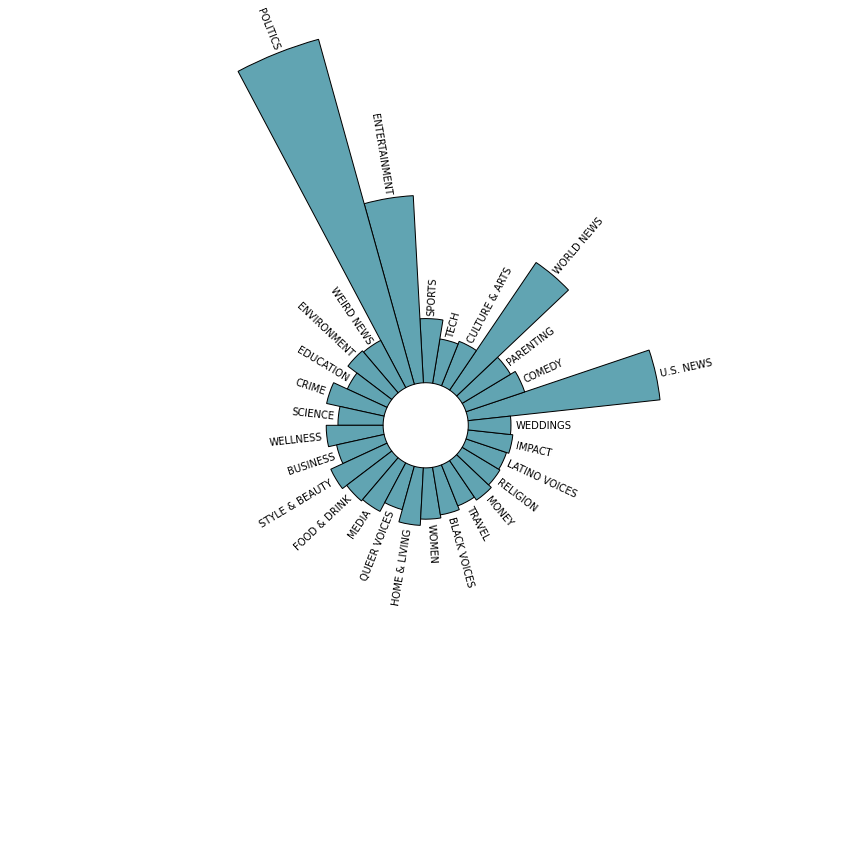

In [15]:
#Applying the function on the extracted category dataset
circular_bar(df_counts, 'Unique_cat', 'counts')

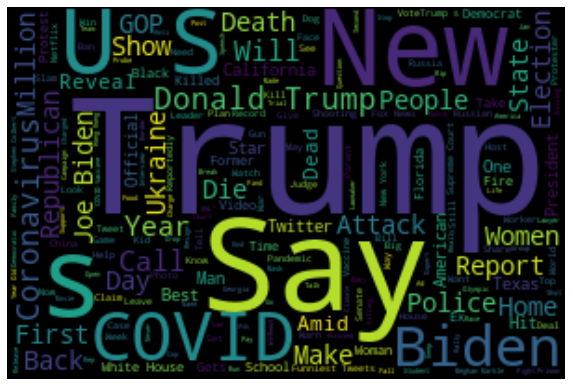

In [16]:
#Word cloud visualization
text=" ".join(i for i in news_df.headline)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 300, height = 200, stopwords=stopwords, background_color="black").generate(text)
plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig("news1.png", format="png") 
plt.show()

# preprocessing

In [17]:
#Concatenating the headline and the short description column
news_df["news_text"] =news_df["headline"] + " " + news_df["short_description"] 

/tmp/ipykernel_5605/2918903318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df["news_text"] =news_df["headline"] + " " + news_df["short_description"]


In [18]:
#Drop unnused columns from the dataset
news_df=news_df.drop(columns=["link", "authors", "category", "date", "short_description"])

In [26]:
news_df

,headline,news_text
0,Over 4 Million Americans Roll Up Sleeves For O...,4 million american roll sleeve omicrontargeted...
1,"American Airlines Flyer Charged, Banned For Li...",american airline flyer charged banned life pun...
2,23 Of The Funniest Tweets About Cats And Dogs ...,23 funniest tweet cat dog week sept 1723 dog d...
3,The Funniest Tweets From Parents This Week (Se...,funniest tweet parent week sept 1723 accidenta...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,woman called cop black birdwatcher loses lawsu...
...,...,...
7518,Alabama Sheriff Pocketed $1.5 Million In ICE F...,alabama sheriff pocketed 15 million ice fund i...
7519,Minivan Slams Into New Year's Revelers In Toky...,minivan slam new year reveler tokyo injuring 8...
7520,Kim Jong Un Says He's Ready To Meet With Trump...,kim jong un say he ready meet trump new year s...
7521,Sandra Bullock's New Netflix Movie Inspires Pe...,sandra bullock new netflix movie inspires peop...


In [19]:
en_stopwords =nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [20]:
#Defining the preprocessing function
def process(text):
    text = re.sub("[^A-Za-z1-9 ]", "", text)
    text = text.lower()
    tokens = word_tokenize(text)
    clean_list = []
    for token in tokens:
        if token not in en_stopwords:
            clean_list.append(lemmatizer.lemmatize(token))
    return " ".join(clean_list)

In [21]:
news_df.news_text = news_df.news_text.apply(process)

In [27]:
news_df.news_text

0       4 million american roll sleeve omicrontargeted...
1       american airline flyer charged banned life pun...
2       23 funniest tweet cat dog week sept 1723 dog d...
3       funniest tweet parent week sept 1723 accidenta...
4       woman called cop black birdwatcher loses lawsu...
                              ...                        
7518    alabama sheriff pocketed 15 million ice fund i...
7519    minivan slam new year reveler tokyo injuring 8...
7520    kim jong un say he ready meet trump new year s...
7521    sandra bullock new netflix movie inspires peop...
7522    pete davidson return stage troubling instagram...
Name: news_text, Length: 7523, dtype: object

# TF-IDF with Cosine similarity model

TF-IDF (Term Frequency-Inverse Document Frequency) is a commonly used technique for information retrieval and text mining. It is used to determine the importance of a particular term (or word) in a given document, relative to other documents in a collection.

TF-IDF is calculated by multiplying two values:

    Term Frequency (TF): This measures the frequency of a term in a document. It is calculated as the number of times the term appears in the document, divided by the total number of terms in the document.

    Inverse Document Frequency (IDF): This measures the importance of a term in the entire collection of documents. It is calculated as the logarithm of the total number of documents in the collection, divided by the number of documents that contain the term.

The TF-IDF value for a given term in a given document is simply the product of its TF and IDF values.

The intuition behind TF-IDF is that terms that occur frequently in a document but rarely in other documents are more important and should be given higher weight in ranking and retrieval tasks. By contrast, terms that occur frequently in many documents are less important and should be given lower weight. TF-IDF is widely used in search engines, text classification, and clustering applications.

In [22]:
vectorizer = TfidfVectorizer()
features   = vectorizer.fit_transform(news_df['news_text'])

get vector of common/important words

plot vector. If angle is 0 ==> similar

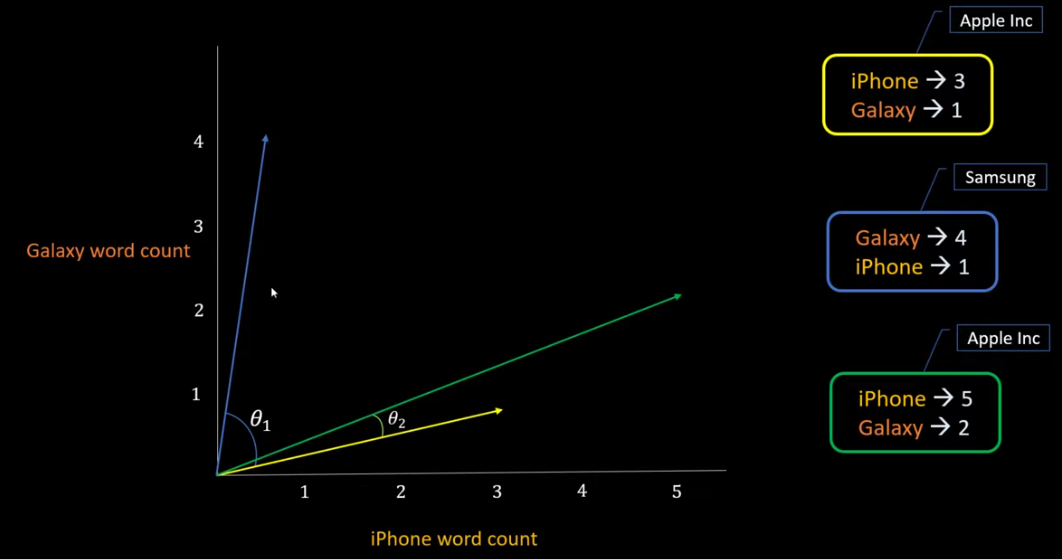

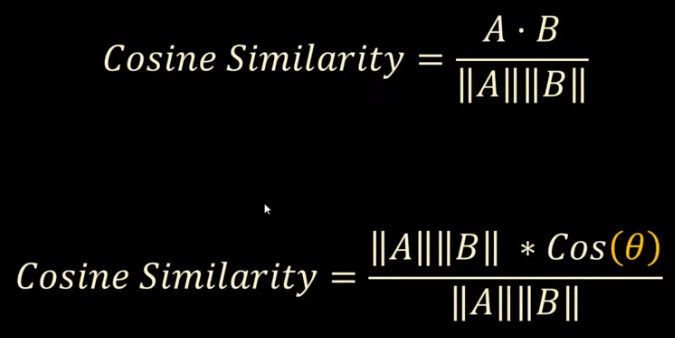

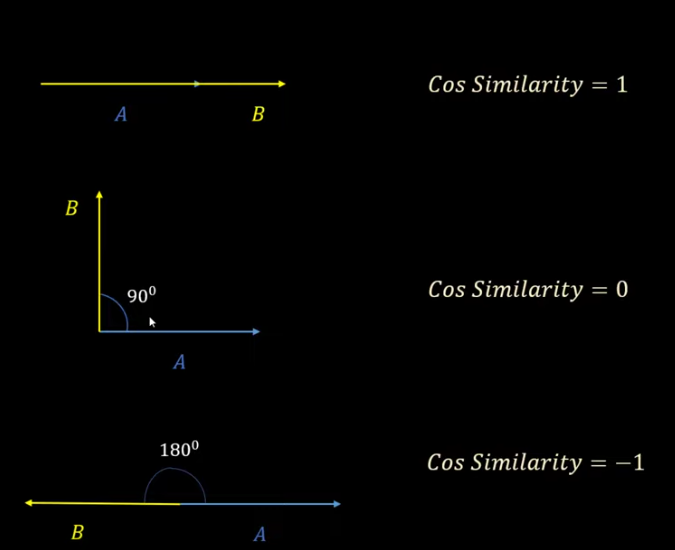

cosine distance = 1 - cosine similarity

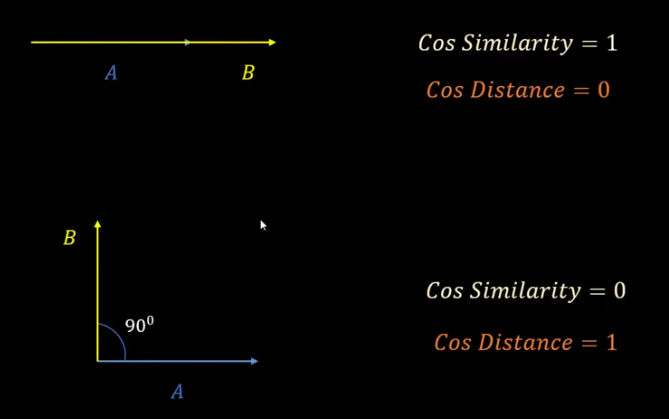

credits: https://www.youtube.com/watch?v=m_CooIRM3UI


blue and yellow ==> not similar

green and yellow ==> similar: cosine similarity is cos17° = 0.95

In [23]:
#Taking the cosine similarity of the vectorized text
cosine_sim = cosine_similarity(features,features)


In [28]:
cosine_sim

array([[1.        , 0.01927518, 0.        , ..., 0.03099527, 0.02564872,
        0.        ],
       [0.01927518, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03099527, 0.        , 0.        , ..., 1.        , 0.07400919,
        0.        ],
       [0.02564872, 0.        , 0.        , ..., 0.07400919, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [24]:
def get_recommended(headline_index, cosine_sim):
    headline=news_df.headline[headline_index]
    indices = pd.Series(news_df.index, index=news_df['headline']).drop_duplicates()
    # Get index of the news headline
    idx = indices[headline]
    # Sort the news headline on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar news headlines
    sim_scores = sim_scores[1:11]
    # Get the headline indices
    scores=[i[1] for i in sim_scores]
    news_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar news headlines
    dfs=pd.DataFrame({'headlines': news_df['headline'].iloc[news_indices],
                'Cosine_similarity':  scores})
    print("*" * 30 + " News Recommendation " + "*" * 30)
    print("")
    print(f"News Headline: {headline}")
    print("")
    print( "*" * 29 + " Recommended News Articles " + "*" * 29)
    return dfs.iloc[0:,]

In [25]:
news_df.headline[2]

'23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23)'

In [29]:
pd.set_option('display.max_colwidth', -1)  # To display a very long headline completely

/tmp/ipykernel_5605/2047283190.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # To display a very long headline completely


In [30]:
recommended=get_recommended(44, cosine_sim)
recommended

****************************** News Recommendation ******************************

News Headline: Mark Meadows Complies With Justice Dept. Subpoena: Report

***************************** Recommended News Articles *****************************


,headlines,Cosine_similarity
763,Mark Meadows Says Jan. 6 Panel Leaked Texts To 'Vilify' Him,0.309251
1485,House Moves Forward With Criminal Charges Against Mark Meadows,0.296283
3988,"Trump Went Through 'Very Concerning' Period After COVID-19 Diagnosis, White House Reveals",0.262066
1509,Mark Meadows Hands Over PowerPoint Plan For Trump To Overthrow Election,0.260786
1337,"Laura Ingraham Feared More Violence After Jan. 6, Newly Released Text Message Shows",0.232550
3804,North Carolina Republican Madison Cawthorn Will Soon Be The Youngest House Member,0.229654
1465,Michael Cohen Slams 'Stupid' Mark Meadows On MSNBC,0.205980
1449,Judge Denies Michael Flynn's Attempt To Block Subpoena For Phone Records In Jan. 6 Probe,0.193740
766,Samantha Bee Stunned By 'Gossipy Little Bitch' Mark Meadows' Text Messages,0.193017
862,DOJ Denies Jan. 6 Panel Details In Trump Records Probe,0.179859


# Word2Vec embedding with Cosine Similarity

Word2vec is a neural network-based approach for representing words as high-dimensional vectors. The word2vec algorithm learns word embeddings, which are vector representations of words that capture the semantic and syntactic relationships between words in a corpus of text. The word embeddings generated by the word2vec algorithm have proven to be very useful for a wide range of natural language processing tasks, such as language modeling, text classification, named entity recognition, sentiment analysis, and machine translation.

The word2vec algorithm has two main architectures: the Continuous Bag of Words (CBOW) and the Skip-gram model. In the CBOW model, the task is to predict the current word based on its context, while in the Skip-gram model, the task is to predict the context words given the current word. Both models use a neural network with one or more hidden layers to learn the word embeddings, which are optimized to minimize the prediction error of the model.

Word2vec has several advantages over traditional methods for representing words, such as one-hot encoding or bag-of-words models. It can capture semantic and syntactic similarities between words, handle out-of-vocabulary words, and support more complex downstream NLP tasks.

In [33]:
#Getting the path to the google pre-trained model
path='/home/ines/Downloads/GoogleNews-vectors-negative300.bin'

In [34]:
google_word2vec = KeyedVectors.load_word2vec_format(path, binary=True)


In [35]:
#Converting the text files into a list of words
corpus = []
for words in news_df['news_text']:
    corpus.append(words.split())


In [36]:
#Generating the word to vec model
google_model = Word2Vec(vector_size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

In [37]:
def vectors(x):
    # Creating a list for storing the vectors (news_text into vectors)
    global word_embeddings
    word_embeddings = []
    vocab = list(google_model.wv.key_to_index)
    # Reading each news_text
    for line in news_df['news_text']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model.wv.get_vector(word, norm=True) 
                else:
                    avgword2vec = avgword2vec + google_model.wv.get_vector(word, norm=True) 
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)

In [38]:
#calling vector function on the dataset
vectors(news_df)  
# finding cosine similarity for the vectors 
cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

In [39]:
#Calling the recommender function
w2vrecommended=get_recommended(44, cosine_similarities)
w2vrecommended

****************************** News Recommendation ******************************

News Headline: Mark Meadows Complies With Justice Dept. Subpoena: Report

***************************** Recommended News Articles *****************************


,headlines,Cosine_similarity
763,Mark Meadows Says Jan. 6 Panel Leaked Texts To 'Vilify' Him,0.411580
1485,House Moves Forward With Criminal Charges Against Mark Meadows,0.322787
1337,"Laura Ingraham Feared More Violence After Jan. 6, Newly Released Text Message Shows",0.305478
1509,Mark Meadows Hands Over PowerPoint Plan For Trump To Overthrow Election,0.303982
191,"Dorli Rainey, Symbol Of Occupy Movement, Dies At 95",0.300021
2829,Top House Republican Defends Trump's Response To Capitol Riot: 'He Put A Video Out',0.298369
2962,Sean Spicer Accidentally On Mute Could Be The Weirdest Interview Of 2021,0.291193
1919,"'Disengaged' Melania Trump Was Asleep On Election Night, New Book Says",0.285531
862,DOJ Denies Jan. 6 Panel Details In Trump Records Probe,0.280234
3988,"Trump Went Through 'Very Concerning' Period After COVID-19 Diagnosis, White House Reveals",0.277127
